# Movie Data Exploration and Analysis

This notebook explores movie data with a focus on:
1. Analyzing genre behavior across countries using release dates
2. Identifying notable actors/directors over time
3. Incorporating auxiliary datasets (TMDB)

In [129]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
from collections import Counter
import re
from tqdm.notebook import tqdm

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Initial Exploration

In [130]:
# Load the main dataset
df_wiki = pd.read_csv('wiki_movie_plots_deduped_cleaned.csv')
print(f"Loaded dataset with {len(df_wiki)} movies")
print(f"Columns: {df_wiki.columns.tolist()}")

Loaded dataset with 34886 movies
Columns: ['Unnamed: 0', 'Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot', 'genres_list', 'Genre_list', 'Cast_list', 'genre_list_raw', 'genre_list', 'plot_clean', 'plot_lemmatized']


In [ ]:
# Display the first few rows
df_wiki.head()

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,Genre_list,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized
0,0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",['unknown'],['unknown'],['nan'],['unknown'],[],a bartender is working at a saloon serving dri...,bartender work saloon serve drink customer fil...
1,1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",['unknown'],['unknown'],['nan'],['unknown'],[],the moon painted with a smiling face hangs ove...,moon paint smile face hang park night young co...
2,2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",['unknown'],['unknown'],['nan'],['unknown'],[],the film just over a minute long is composed o...,film minute long compose shot girl sit base al...
3,3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,['unknown'],['unknown'],['nan'],['unknown'],[],lasting just seconds and consisting of two sho...,last second consist shot shot set wood winter ...
4,4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,['unknown'],['unknown'],['nan'],['unknown'],[],the earliest known adaptation of the classic f...,early know adaptation classic fairytale film s...


In [131]:
# Check for missing values
missing_values = df_wiki.isnull().sum()
print("Missing values per column:")
for col, count in missing_values[missing_values > 0].items():
    print(f"{col}: {count} ({count/len(df_wiki)*100:.2f}%)")

Missing values per column:
Cast: 1422 (4.08%)
Genre: 28 (0.08%)


In [132]:
# Fill missing values in 'Cast' and 'Genre' columns
df_wiki['Cast'] = df_wiki['Cast'].fillna('Unknown')
df_wiki['Genre'] = df_wiki['Genre'].fillna('Unknown')

In [133]:
df_wiki[df_wiki['Genre']!='unknown']

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,Genre_list,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized
6,6,1903,The Great Train Robbery,American,Edwin S. Porter,Unknown,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,['western'],['western'],['nan'],['western'],['western'],the film opens with two bandits breaking into ...,film open bandit break railroad telegraph offi...
7,7,1904,The Suburbanite,American,Wallace McCutcheon,Unknown,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,['comedy'],['comedy'],['nan'],['comedy'],['comedy'],the film is about a family who move to the sub...,film family suburb hope quiet life thing start...
10,10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,Unknown,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...,['short'],['short'],['nan'],['short'],[],the rarebit fiend gorges on welsh rarebit at a...,rarebit fiend gorge welsh rarebit restaurant l...
11,11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,Unknown,"short action,crime western",https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...,['short action/crime western'],"['short action', 'crime western']",['nan'],"['short action', 'crime western']","['crime', 'action']",the film features a train traveling through th...,film feature train travel rockie hold create t...
12,12,1906,Kathleen Mavourneen,American,Edwin S. Porter,Unknown,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...,['short film'],['short film'],['nan'],['short film'],[],irish villager kathleen is a tenant of captain...,irish villager kathleen tenant captain clearfi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34877,34877,2013,Particle (film),Turkish,Erdem Tepegöz,"Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz...",drama film,https://en.wikipedia.org/wiki/Particle_(film),"Zeynep lost her job at weaving factory, and he...",['drama film'],['drama film'],"['Jale Arıkan', 'Rüçhan Caliskur', 'Özay Fecht...",['drama film'],['drama'],zeynep lost her job at weaving factory and her...,zeynep lose job weave factory family mother ha...
34882,34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",['comedy'],['comedy'],"['Ahmet Kural', 'Murat Cemcir']",['comedy'],['comedy'],two musicians salih and grkan described the ad...,musician salih grkan describe adventure cousin
34883,34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",['comedy'],['comedy'],"['Ata Demirer', 'Tuvana Türkay', 'Ülkü Duru']",['comedy'],['comedy'],zafer a sailor living with his mother dnd in a...,zafer sailor live mother dnd coastal village i...
34884,34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,['romantic comedy'],['romantic comedy'],"['YouTubers Shanna Malcolm', 'Shira Lazar', 'S...",['romantic comedy'],['comedy'],the film centres around a young woman named am...,film centre young woman name amy tyler book su...


In [135]:
# Define all known genres and their aliases
known_genres = {
    'action': ['action'],
    'adventure': ['adventure'],
    'animation': ['animation', 'animated'],
    'biography': ['biography', 'bio'],
    'comedy': ['comedy', 'comedies'],
    'crime': ['crime'],
    'documentary': ['documentary', 'doc'],
    'drama': ['drama'],
    'family': ['family'],
    'fantasy': ['fantasy'],
    'history': ['history', 'historical'],
    'horror': ['horror'],
    'music': ['music', 'musical', 'musicals'],
    'mystery': ['mystery'],
    'romance': ['romance', 'romantic'],
    'sci-fi': ['sci-fi', 'science fiction', 'scifi', 'science-fiction'],
    'sport': ['sport', 'sports'],
    'thriller': ['thriller'],
    'war': ['war'],
    'western': ['western'],
    'unknown': ['unknown']
}

# Create a mapping from alias to canonical genre
alias_to_genre = {}
for genre, aliases in known_genres.items():
    for alias in aliases:
        alias_to_genre[alias.lower()] = genre

def extract_genres_from_string(genre_str):
    if not isinstance(genre_str, str):
        return ['unknown']
    # Lowercase and split by comma or slash or semicolon
    tokens = re.split(r'[,/;]', genre_str.lower())
    genres_found = set()
    for token in tokens:
        token = token.strip()
        if token in alias_to_genre:
            genres_found.add(alias_to_genre[token])
        else:
            # Try partial match for multi-word genres
            for alias, genre in alias_to_genre.items():
                if alias in token:
                    genres_found.add(genre)
    if not genres_found:
        return ['unknown']
    return list(genres_found)

# Apply to the 'Genre' column to create a clean genre list
df_wiki['genres_list'] = df_wiki['Genre'].apply(extract_genres_from_string)

In [136]:
df_wiki['genres_list'].iloc[34881]

['unknown']

In [137]:
df_tmdb_credits = pd.read_csv('tmdb_5000_credits.csv')
df_tmdb_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [138]:
import json

# Extract director and top_cast from the 'cast' column in df_tmdb_credits


def parse_json_column(json_str):
    try:
        return json.loads(json_str.replace("''", "'"))
    except Exception:
        return []

# Parse cast and crew columns
df_tmdb_credits['cast_parsed'] = df_tmdb_credits['cast'].apply(parse_json_column)
df_tmdb_credits['crew_parsed'] = df_tmdb_credits['crew'].apply(parse_json_column)

# Extract director from crew
def get_director(crew_list):
    for crew_member in crew_list:
        if isinstance(crew_member, dict) and crew_member.get('job') == 'Director':
            return crew_member.get('name')
    return None

df_tmdb_credits['director'] = df_tmdb_credits['crew_parsed'].apply(get_director)

# Extract top 3 cast members
def get_top_cast(cast_list, n=3):
    return [cast_member.get('name') for cast_member in cast_list[:n] 
            if isinstance(cast_member, dict) and 'name' in cast_member]

df_tmdb_credits['top_cast'] = df_tmdb_credits['cast_parsed'].apply(lambda x: get_top_cast(x))

In [139]:
df_tmdb_credits

,movie_id,title,cast,crew,cast_parsed,crew_parsed,director,top_cast
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]"
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]"
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]"
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]"
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]"
...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...","[{'cast_id': 1, 'character': 'El Mariachi', 'c...","[{'credit_id': '52fe44eec3a36847f80b280b', 'de...",Robert Rodriguez,"[Carlos Gallardo, Jaime de Hoyos, Peter Marqua..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...","[{'cast_id': 1, 'character': 'Buzzy', 'credit_...","[{'credit_id': '52fe487dc3a368484e0fb013', 'de...",Edward Burns,"[Edward Burns, Kerry Bishé, Marsha Dietlein]"
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...","[{'cast_id': 8, 'character': 'Oliver O’Toole',...","[{'credit_id': '52fe4df3c3a36847f8275ecf', 'de...",Scott Smith,"[Eric Mabius, Kristin Booth, Crystal Lowe]"
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de...","[{'cast_id': 3, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe4ad9c3a368484e16a36b', 'de...",Daniel Hsia,"[Daniel Henney, Eliza Coupe, Bill Paxton]"


In [140]:
def extract_director_and_cast(cast_str):
    director = None
    cast_list = []
    if isinstance(cast_str, str):
        # Look for 'Director:' and 'Cast:' patterns
        director_match = re.search(r'Director:\s*([^\r\n]+)', cast_str)
        if director_match:
            director = director_match.group(1).strip()
        cast_match = re.search(r'Cast:\s*([^\r\n]+)', cast_str)
        if cast_match:
            cast_names = cast_match.group(1)
            cast_list = [name.strip() for name in cast_names.split(',') if name.strip()]
        else:
            # If no 'Cast:' pattern, try splitting the whole string by commas
            if not director_match:
                cast_list = [name.strip() for name in cast_str.split(',') if name.strip()]
    return pd.Series({'Director': director, 'Cast_list': cast_list})

df_wiki[['Director', 'Cast_list']] = df_wiki['Cast'].apply(extract_director_and_cast)

In [141]:
df_wiki[df_wiki['Cast']!='Unknown'].head()

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,Genre_list,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized
5,5,1903,Alice in Wonderland,American,None,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...",[unknown],['unknown'],[May Clark],['unknown'],[],alice follows a large white rabbit down a rabb...,alice follow large white rabbit rabbithole fin...
13,13,1907,Daniel Boone,American,None,"William Craven, Florence Lawrence",biographical,https://en.wikipedia.org/wiki/Daniel_Boone_(19...,Boone's daughter befriends an Indian maiden as...,[biography],['biographical'],"[William Craven, Florence Lawrence]",['biographical'],[],boones daughter befriends an indian maiden as ...,boone daughter befriend indian maiden boone co...
15,15,1907,Laughing Gas,American,None,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,[comedy],['comedy'],"[Bertha Regustus, Edward Boulden]",['comedy'],['comedy'],the plot is that of a black woman going to the...,plot black woman go dentist toothache give lau...
16,16,1908,The Adventures of Dollie,American,None,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,[drama],['drama'],"[Arthur V. Johnson, Linda Arvidson]",['drama'],['drama'],on a beautiful summer day a father and mother ...,beautiful summer day father mother daughter do...
17,17,1908,The Black Viper,American,None,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,[drama],['drama'],[D. W. Griffith],['drama'],['drama'],a thug accosts a girl as she leaves her workpl...,thug accost girl leave workplace man rescue th...


In [145]:
# Prepare lowercase title columns for merging
df_tmdb_credits['title_lower'] = df_tmdb_credits['title'].str.lower()
df_wiki['Title_lower'] = df_wiki['Title'].str.lower()


In [146]:
df_wiki.head(2)

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,Genre_list,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized,Title_lower
0,0,1901,Kansas Saloon Smashers,American,None,Unknown,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",[unknown],['unknown'],[Unknown],['unknown'],[],a bartender is working at a saloon serving dri...,bartender work saloon serve drink customer fil...,kansas saloon smashers
1,1,1901,Love by the Light of the Moon,American,None,Unknown,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",[unknown],['unknown'],[Unknown],['unknown'],[],the moon painted with a smiling face hangs ove...,moon paint smile face hang park night young co...,love by the light of the moon


In [147]:
# Merge TMDB director and top_cast into df_wiki using movie title (case-insensitive)
df_merged = pd.merge(
    df_wiki,
    df_tmdb_credits[['title_lower', 'director', 'top_cast']],
    left_on='Title_lower',
    right_on='title_lower',
    how='left'
)


In [148]:
df_merged

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,Genre_list,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized,Title_lower,title_lower,director,top_cast
0,0,1901,Kansas Saloon Smashers,American,None,Unknown,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",[unknown],['unknown'],[Unknown],['unknown'],[],a bartender is working at a saloon serving dri...,bartender work saloon serve drink customer fil...,kansas saloon smashers,NaN,NaN,NaN
1,1,1901,Love by the Light of the Moon,American,None,Unknown,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",[unknown],['unknown'],[Unknown],['unknown'],[],the moon painted with a smiling face hangs ove...,moon paint smile face hang park night young co...,love by the light of the moon,NaN,NaN,NaN
2,2,1901,The Martyred Presidents,American,None,Unknown,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",[unknown],['unknown'],[Unknown],['unknown'],[],the film just over a minute long is composed o...,film minute long compose shot girl sit base al...,the martyred presidents,NaN,NaN,NaN
3,3,1901,"Terrible Teddy, the Grizzly King",American,None,Unknown,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,[unknown],['unknown'],[Unknown],['unknown'],[],lasting just seconds and consisting of two sho...,last second consist shot shot set wood winter ...,"terrible teddy, the grizzly king",NaN,NaN,NaN
4,4,1902,Jack and the Beanstalk,American,None,Unknown,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,[unknown],['unknown'],[Unknown],['unknown'],[],the earliest known adaptation of the classic f...,early know adaptation classic fairytale film s...,jack and the beanstalk,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34886,34881,2014,The Water Diviner,Turkish,Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",[unknown],['unknown'],"[Russell Crowe, Olga Kurylenko, Jai Courtney, ...",['unknown'],[],the film begins in just after world war i has ...,film begin world war end centre joshua connor ...,the water diviner,the water diviner,Russell Crowe,"[Russell Crowe, Olga Kurylenko, Yılmaz Erdoğan]"
34887,34882,2017,Çalgı Çengi İkimiz,Turkish,None,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",[comedy],['comedy'],"[Ahmet Kural, Murat Cemcir]",['comedy'],['comedy'],two musicians salih and grkan described the ad...,musician salih grkan describe adventure cousin,çalgı çengi i̇kimiz,NaN,NaN,NaN
34888,34883,2017,Olanlar Oldu,Turkish,None,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",[comedy],['comedy'],"[Ata Demirer, Tuvana Türkay, Ülkü Duru]",['comedy'],['comedy'],zafer a sailor living with his mother dnd in a...,zafer sailor live mother dnd coastal village i...,olanlar oldu,NaN,NaN,NaN
34889,34884,2017,Non-Transferable,Turkish,None,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,"[romance, comedy]",['romantic comedy'],"[YouTubers Shanna Malcolm, Shira Lazar, Sara F...",['romantic comedy'],['comedy'],the film centres around a young woman named am...,film centre young woman name amy tyler book su...,non-transferable,NaN,NaN,NaN


In [149]:


# Update Director: fill nulls in original Director with TMDB director
df_wiki['Director'] = df_wiki['Director'].combine_first(df_merged['director'])

# Update Cast_list: merge existing Cast_list with TMDB top_cast, ensure list type and uniqueness
def merge_cast_lists(row):
    orig_cast = row['Cast_list']
    tmdb_cast = row['top_cast']
    # Convert to list if not already
    orig_cast = orig_cast if isinstance(orig_cast, list) else []
    tmdb_cast = tmdb_cast if isinstance(tmdb_cast, list) else []
    # Merge and deduplicate
    return list({*orig_cast, *tmdb_cast})

df_wiki['Cast_list'] = df_merged.apply(merge_cast_lists, axis=1)

In [150]:
# Basic statistics
print(f"Time span: {df_wiki['Release Year'].min()} to {df_wiki['Release Year'].max()}")


# Count unique genres, countries, directors, and cast members
all_genres = [genre for sublist in df_wiki['genres_list'] for genre in sublist if isinstance(sublist, list)]
unique_genres = set(all_genres)
print(f"Number of unique genres: {len(unique_genres)}")
print(f"Unique genres: {sorted(unique_genres)}")

unique_countries = df_wiki['Origin/Ethnicity'].nunique()
print(f"Number of unique countries/origins: {unique_countries}")

unique_directors = df_wiki['Director'].nunique()
print(f"Number of unique directors: {unique_directors}")

Time span: 1901 to 2017
Number of unique genres: 21
Unique genres: ['action', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance', 'sci-fi', 'sport', 'thriller', 'unknown', 'war', 'western']
Number of unique countries/origins: 24
Number of unique directors: 1947


C:\Users\161070\AppData\Local\Temp\ipykernel_56064\3100640696.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




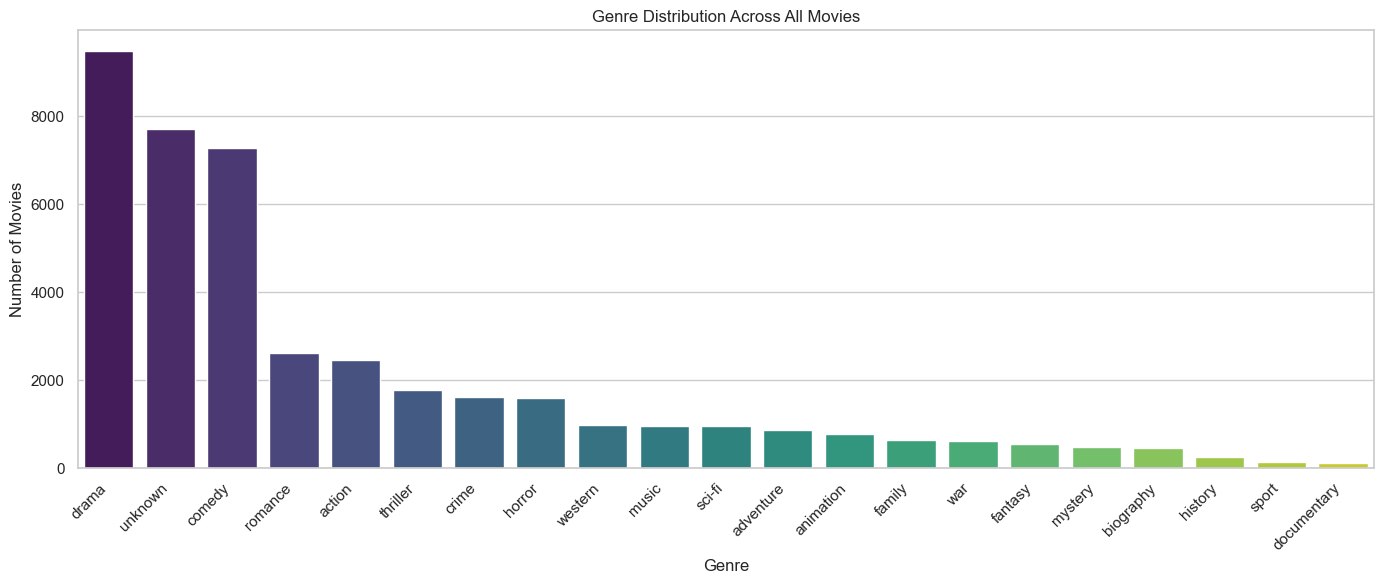

In [151]:
from collections import Counter

# Calculate genre distribution (counts) across all movies

# Flatten the list of genres from all movies
all_genres_flat = [genre for genres in df_wiki['genres_list'] if isinstance(genres, list) for genre in genres]
genre_counts = Counter(all_genres_flat)

# Convert to DataFrame for plotting
genre_dist_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values('Count', ascending=False)

# Plot genre distribution
plt.figure(figsize=(14, 6))
sns.barplot(x='Genre', y='Count', data=genre_dist_df, palette='viridis')
plt.title('Genre Distribution Across All Movies')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Genre Analysis by Country and Over Time

In [104]:
# Create a decade column for temporal analysis
df_wiki['Decade'] = (df_wiki['Release Year'] // 10) * 10

# Filter out rows with invalid decades (too old or missing)
df_wiki_filtered = df_wiki[(df_wiki['Decade'] >= 1900) & (df_wiki['Decade'] <= 2020)]
print(f"Movies after filtering by decade: {len(df_wiki_filtered)}")

Movies after filtering by decade: 34886


Top 10 countries by movie count: ['American', 'British', 'Bollywood', 'Tamil', 'Telugu', 'Japanese', 'Malayalam', 'Hong Kong', 'Canadian', 'Australian']


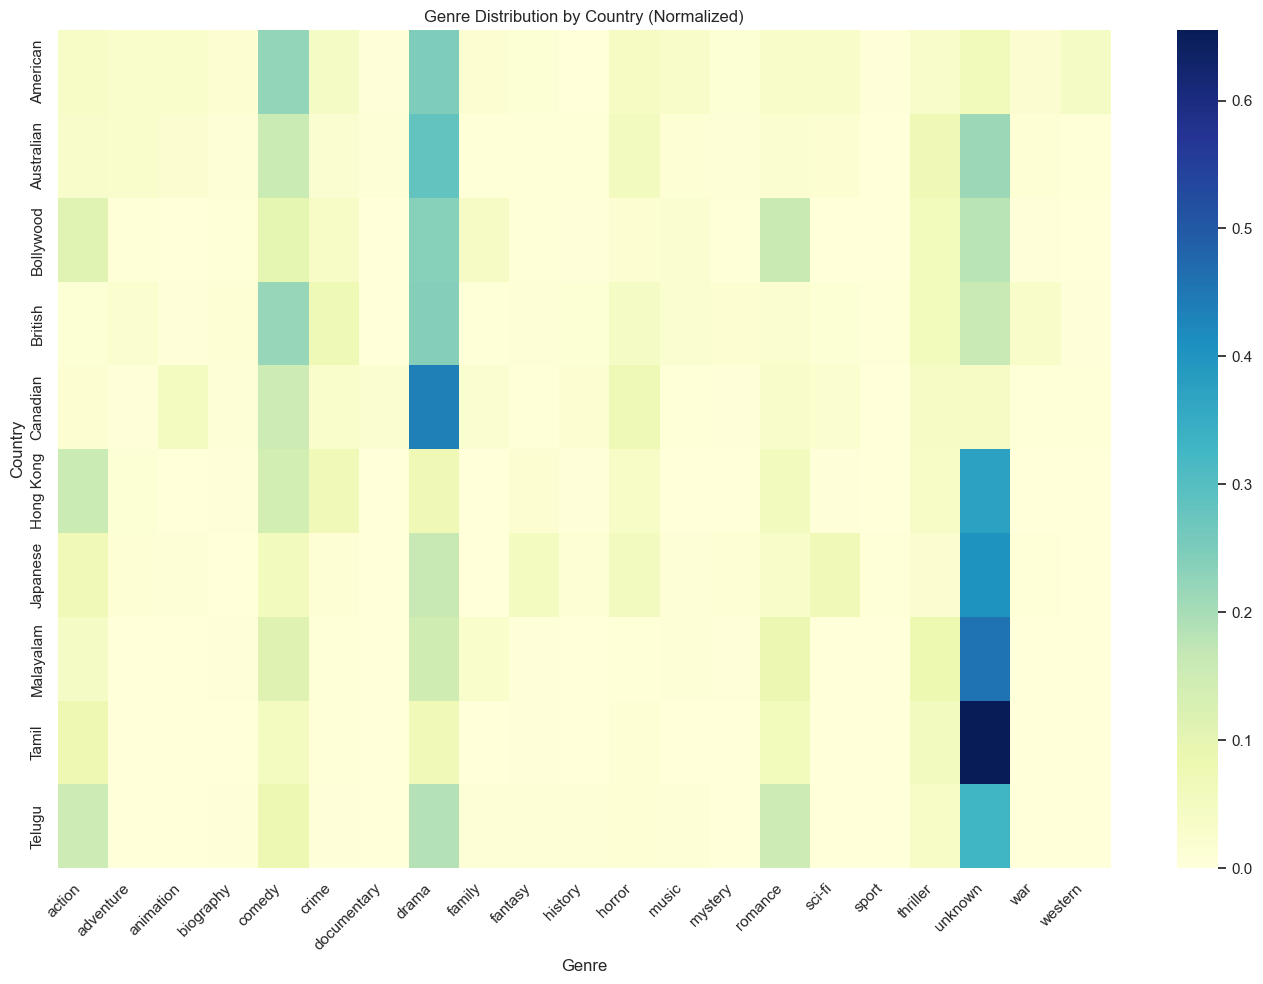

In [105]:
# Analyze genre distribution by country
# First, get the top 10 countries by movie count
top_countries = df_wiki['Origin/Ethnicity'].value_counts().head(10).index.tolist()
print(f"Top 10 countries by movie count: {top_countries}")

# Create a dataframe with country and exploded genres
country_genre_df = df_wiki[df_wiki['Origin/Ethnicity'].isin(top_countries)].copy()
country_genre_df = country_genre_df.explode('genres_list')

# Plot genre distribution for top countries
plt.figure(figsize=(14, 10))
country_genre_pivot = pd.crosstab(country_genre_df['Origin/Ethnicity'], country_genre_df['genres_list'])
country_genre_pivot_norm = country_genre_pivot.div(country_genre_pivot.sum(axis=1), axis=0)
sns.heatmap(country_genre_pivot_norm, cmap='YlGnBu', annot=False, fmt='.2f')
plt.title('Genre Distribution by Country (Normalized)')
plt.ylabel('Country')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

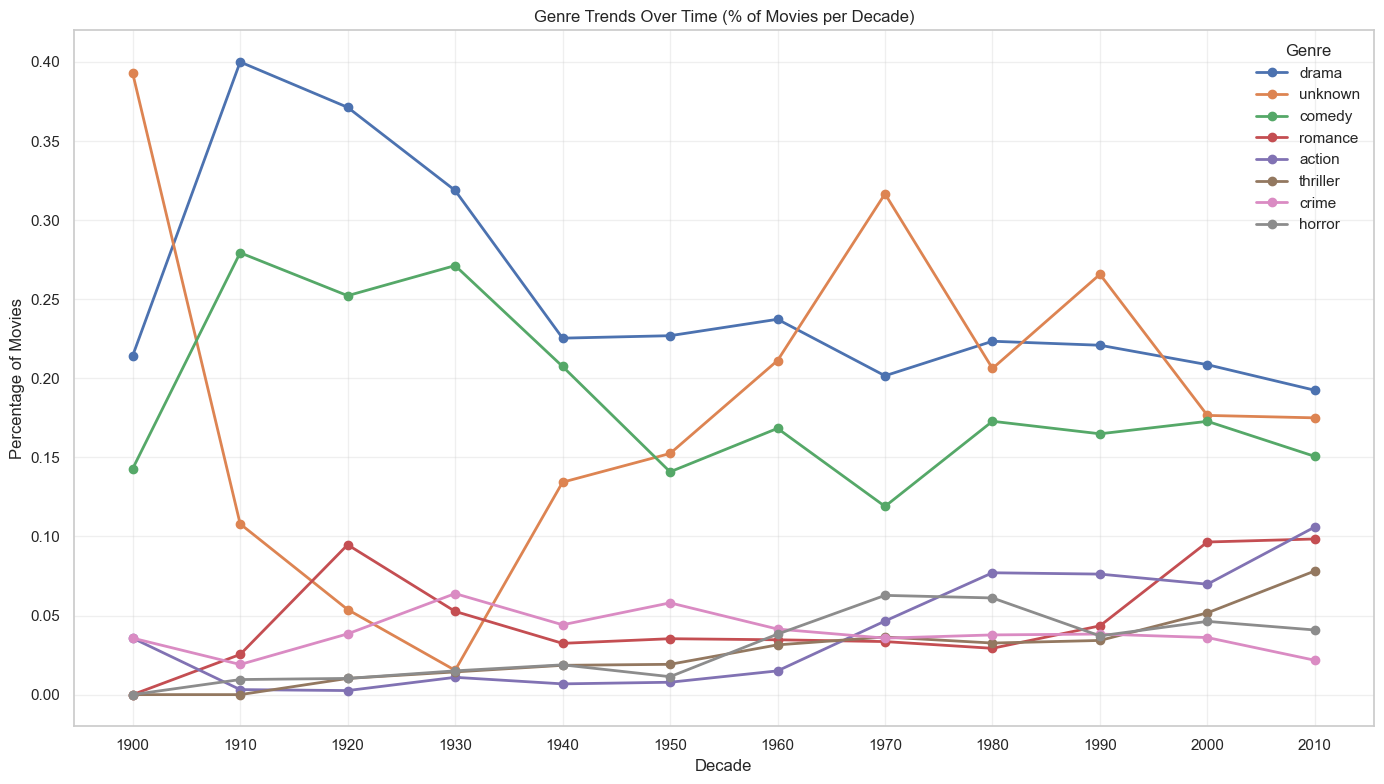

In [152]:
# Analyze genre trends over time
# Create a dataframe with decade and exploded genres
decade_genre_df = df_wiki_filtered.copy()
decade_genre_df = decade_genre_df.explode('genres_list')

# Count genres by decade
decade_genre_counts = decade_genre_df.groupby(['Decade', 'genres_list']).size().reset_index(name='count')

# Pivot the data for plotting
decade_genre_pivot = decade_genre_counts.pivot(index='Decade', columns='genres_list', values='count').fillna(0)

# Normalize by decade to show percentage
decade_genre_pivot_norm = decade_genre_pivot.div(decade_genre_pivot.sum(axis=1), axis=0)

# Plot the trends for top genres
top_genres = decade_genre_df['genres_list'].value_counts().head(8).index.tolist()
plt.figure(figsize=(14, 8))
for genre in top_genres:
    if genre in decade_genre_pivot_norm.columns:
        plt.plot(decade_genre_pivot_norm.index, decade_genre_pivot_norm[genre], marker='o', linewidth=2, label=genre)

plt.title('Genre Trends Over Time (% of Movies per Decade)')
plt.xlabel('Decade')
plt.ylabel('Percentage of Movies')
plt.legend(title='Genre')
plt.grid(True, alpha=0.3)
plt.xticks(decade_genre_pivot_norm.index)
plt.tight_layout()
plt.show()

In [107]:
# Create a choropleth map of genre distribution by country
# First, install necessary packages if not already installed
!pip install plotly country_converter



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [108]:
df_wiki['Origin/Ethnicity']

0        American
1        American
2        American
3        American
4        American
           ...   
34881     Turkish
34882     Turkish
34883     Turkish
34884     Turkish
34885     Turkish
Name: Origin/Ethnicity, Length: 34886, dtype: object

In [153]:
iso_country = pd.read_csv('https://raw.githubusercontent.com/knowitall/chunkedextractor/refs/heads/master/src/main/resources/edu/knowitall/chunkedextractor/demonyms.csv',names=['country','country_code'])
iso_country

,country,country_code
0,Aalborgenser,Aalborg
1,Aberdonian,Aberdeen
2,Abkhaz,Abkhazia
3,Abkhazian,Abkhazia
4,Abrenian,Abra
...,...,...
2139,Zimbabwean,Zimbabwe
2140,Zintani,Zintan
2141,Zulu,Zululand
2142,Zuricher,Zurich


In [154]:
iso_country[iso_country['country']=='American']['country_code'].values[0]


'United States'

In [155]:

country_counts = df_wiki['Origin/Ethnicity'].value_counts().reset_index()
country_counts

,Origin/Ethnicity,count
0,American,17377
1,British,3670
2,Bollywood,2931
3,Tamil,2599
4,Telugu,1311
5,Japanese,1188
6,Malayalam,1095
7,Hong Kong,791
8,Canadian,723
9,Australian,576


In [156]:
import country_converter as coco


In [157]:

#didn't work-----------------------------------
# Function to convert country names to ISO codes
def convert_to_iso(country_name):
    try:
        
        return coco.convert(names=iso_country[iso_country['country']==country_name]['country_code'].values[0], to='ISO3')
    except:
        return None



# Get genre counts by country
country_counts = df_wiki['Origin/Ethnicity'].value_counts().reset_index()
country_counts.columns = ['country', 'movie_count']

# Convert country names to ISO codes
country_counts['iso_code'] = country_counts['country'].apply(convert_to_iso)


Tamil Nadu not found in regex
Bengal not found in regex
Punjab not found in regex
Assam not found in regex


In [158]:
country_counts

,country,movie_count,iso_code
0,American,17377,USA
1,British,3670,GBR
2,Bollywood,2931,None
3,Tamil,2599,not found
4,Telugu,1311,None
5,Japanese,1188,JPN
6,Malayalam,1095,None
7,Hong Kong,791,HKG
8,Canadian,723,CAN
9,Australian,576,AUS


In [115]:
!pip install --upgrade nbformat


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [116]:
import nbformat
print(nbformat.__version__)

5.10.4


In [117]:
country_counts

,country,movie_count,iso_code
0,American,17377,USA
1,British,3670,GBR
2,Bollywood,2931,None
3,Tamil,2599,not found
4,Telugu,1311,None
5,Japanese,1188,JPN
6,Malayalam,1095,None
7,Hong Kong,791,HKG
8,Canadian,723,CAN
9,Australian,576,AUS


In [159]:
from urllib.request import urlopen

import plotly.express as px



# Create choropleth map
fig = px.choropleth(country_counts, 
                    locations="iso_code",
                    color="movie_count",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Movie Count by Country")
fig.show()

## 3. Actor and Director Analysis

In [160]:
print(df_wiki[['Cast','Cast_list']].iloc[34881])

Cast         Director: Russell Crowe\r\nCast: Russell Crowe...
Cast_list    [Selma Alispahic, Bucin Abdullah, Tina Cvitano...
Name: 34881, dtype: object


In [161]:

# Count movie appearances for each actor
actor_counts = {}
for cast_list in df_wiki['Cast_list']:
    if isinstance(cast_list, list):
        for actor in cast_list:
            if actor and actor != 'nan':
                actor_counts[actor] = actor_counts.get(actor, 0) + 1

# Get top actors
top_actors = sorted(actor_counts.items(), key=lambda x: x[1], reverse=True)[:20]
top_actors_df = pd.DataFrame(top_actors, columns=['Actor', 'Movie Count'])
print("Top 20 actors by movie count:")
top_actors_df

Top 20 actors by movie count:


,Actor,Movie Count
0,Unknown,1423
1,Jr.,232
2,Mithun Chakraborty,154
3,Jeetendra,151
4,Sivaji Ganesan,131
5,Prakash Raj,126
6,Mohanlal,121
7,Pran,121
8,Dharmendra,117
9,M. G. Ramachandran,115


In [121]:
# Count movie appearances for each director
director_counts = df_wiki['Director'].value_counts().reset_index()
director_counts.columns = ['Director', 'Movie Count']
top_directors = director_counts.head(20)
print("Top 20 directors by movie count:")
top_directors

Top 20 directors by movie count:


,Director,Movie Count
0,Ridley Scott,27
1,Steven Spielberg,23
2,Tim Burton,23
3,Martin Scorsese,22
4,Clint Eastwood,20
5,Woody Allen,19
6,Kenneth Branagh,19
7,Joel Schumacher,18
8,Robert Zemeckis,18
9,Renny Harlin,16


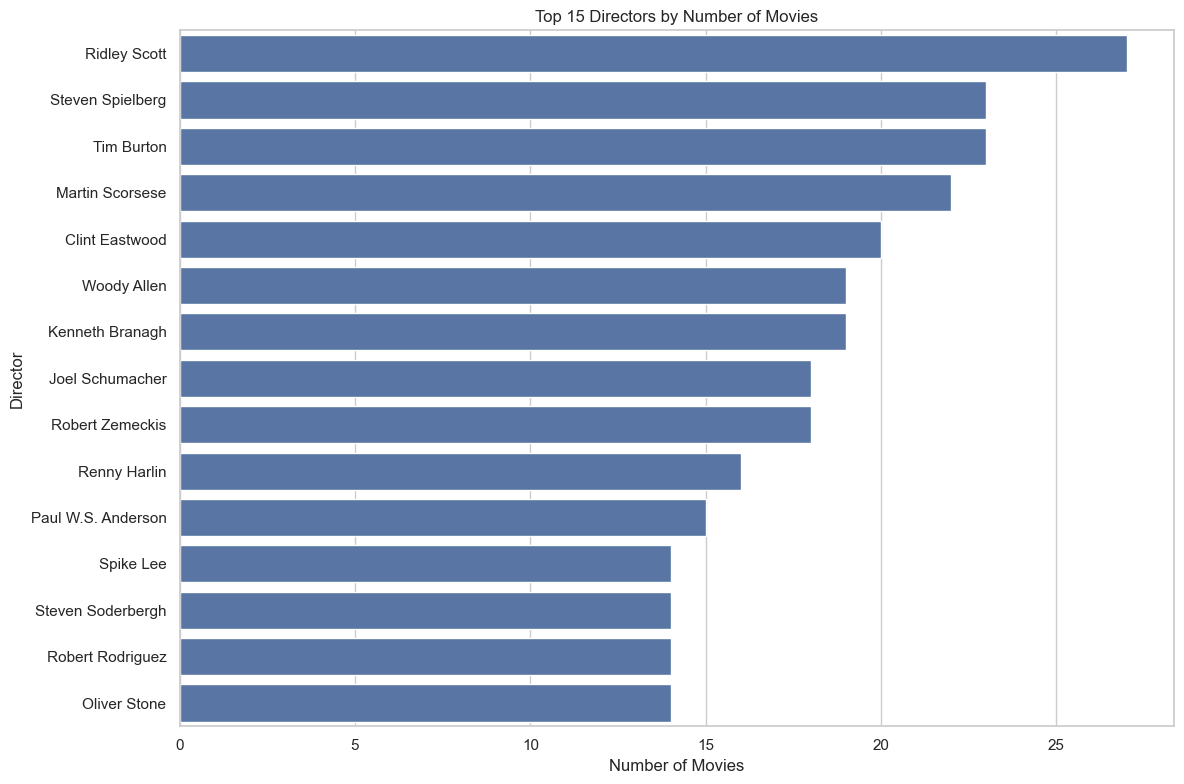

In [162]:
# Visualize top directors
plt.figure(figsize=(12, 8))
sns.barplot(x='Movie Count', y='Director', data=top_directors.head(15))
plt.title('Top 15 Directors by Number of Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

In [164]:
df_separated = df_wiki.explode('genres_list')

In [ ]:
# Add a new column with value 1/count of movies for each director
director_movie_counts = df_wiki['Director'].value_counts()
df_separated['director_movie_weight'] = df_separated['Director'].map(lambda d: 1 / director_movie_counts[d] if pd.notna(d) and d in director_movie_counts else np.nan)

In [174]:
# Add a new column with value 1/count of movies for each director
gen_director_movie_counts = df_separated['genres_list'].value_counts()
df_separated['movie_director_weight'] = df_separated['genres_list'].map(lambda d: 1 / gen_director_movie_counts[d] if pd.notna(d) and d in gen_director_movie_counts else np.nan)

In [177]:
# Create a pivot table: directors as rows, genres as columns, values as sum of director_movie_weight
director_genre_weight_pivot = df_separated.pivot_table(
    index='Director',
    columns='genres_list',
    values='director_movie_weight',
    aggfunc='sum',
    fill_value=0
)

import plotly.express as px

fig = px.imshow(
    director_genre_weight_pivot,
    labels=dict(x="Genre", y="Director", color="Weighted Sum"),
    x=director_genre_weight_pivot.columns,
    y=director_genre_weight_pivot.index,
    aspect="auto",
    color_continuous_scale="YlGnBu",
)
fig.update_layout(title="Weighted Genre Distribution for Directors (normalized for director)")
fig.show()

In [175]:
df_separated['movie_director_weight']

0        0.000130
1        0.000130
2        0.000130
3        0.000130
4        0.000130
           ...   
34882    0.000138
34883    0.000138
34884    0.000382
34884    0.000138
34885    0.000382
Name: movie_director_weight, Length: 42241, dtype: float64

In [178]:
# Create a pivot table: directors as rows, genres as columns, values as sum of director_movie_weight
director_genre_weight_pivot = df_separated.pivot_table(
    index='Director',
    columns='genres_list',
    values='movie_director_weight',
    aggfunc='sum',
    fill_value=0
)

import plotly.express as px

fig = px.imshow(
    director_genre_weight_pivot,
    labels=dict(x="Genre", y="Director", color="Weighted Sum"),
    x=director_genre_weight_pivot.columns,
    y=director_genre_weight_pivot.index,
    aspect="auto",
    color_continuous_scale="YlGnBu",
)
fig.update_layout(title="Weighted Genre Distribution for Directors (normalized for Genre)")
fig.show()

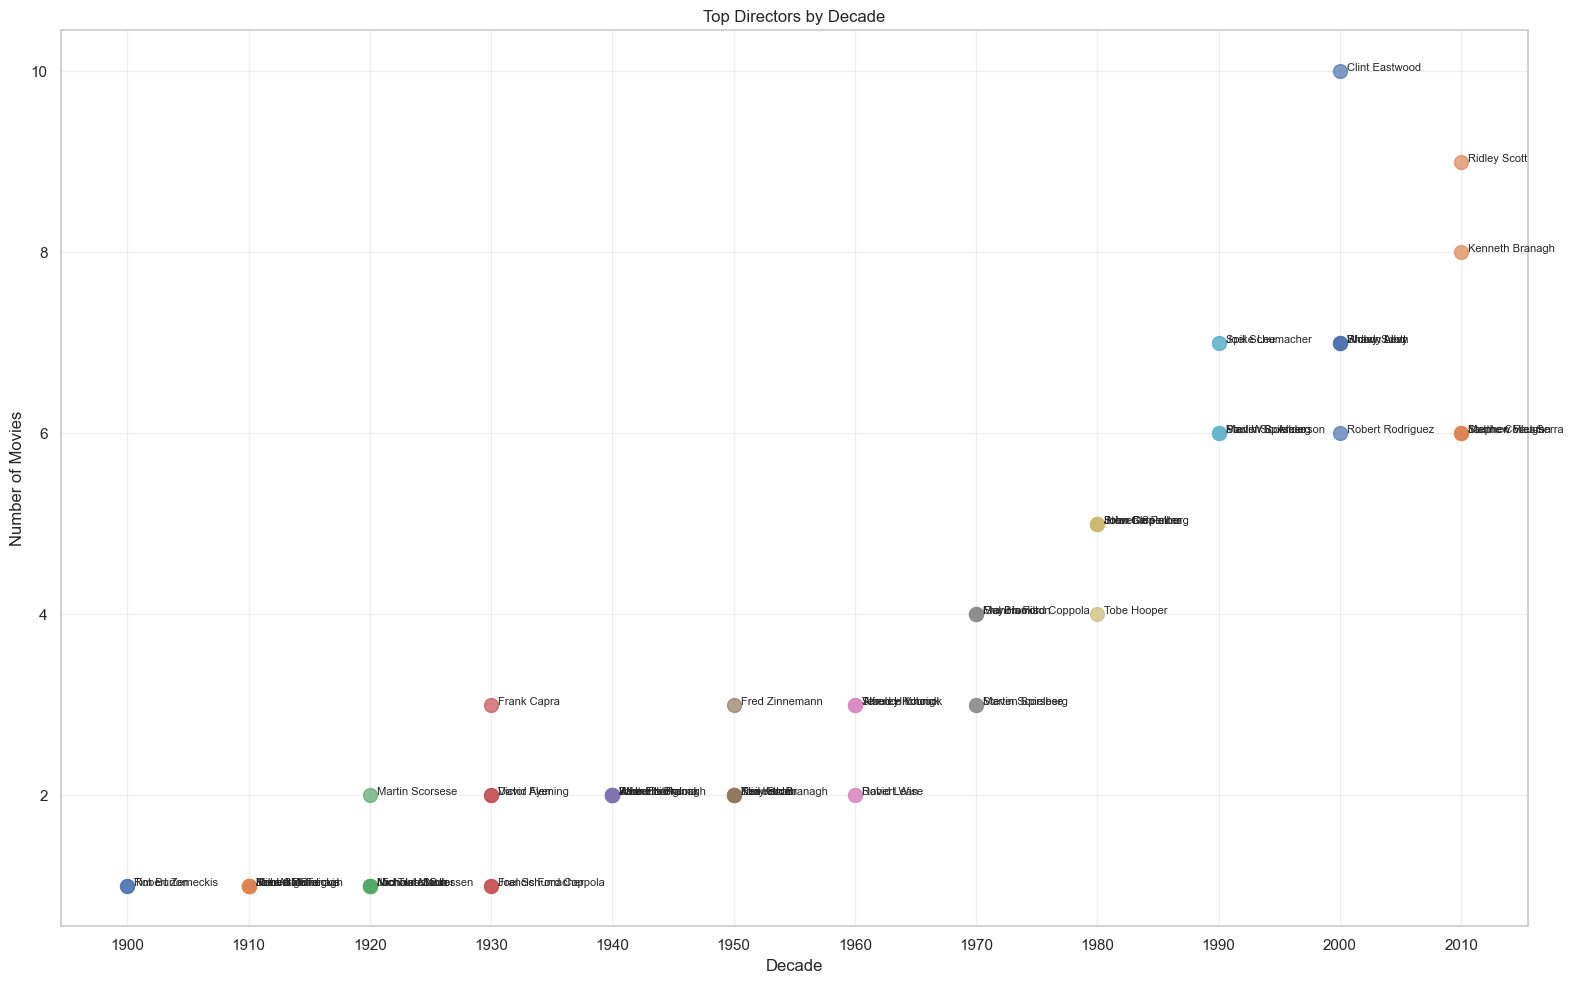

In [123]:
# Analyze directors over time
# Get top 5 directors for each decade
top_directors_by_decade = {}
for decade in sorted(df_wiki_filtered['Decade'].unique()):
    decade_df = df_wiki_filtered[df_wiki_filtered['Decade'] == decade]
    top_directors_by_decade[decade] = decade_df['Director'].value_counts().head(5).to_dict()

# Create a dataframe for visualization
directors_decade_data = []
for decade, directors in top_directors_by_decade.items():
    for director, count in directors.items():
        if pd.notna(director) and director != '':
            directors_decade_data.append({'Decade': decade, 'Director': director, 'Movie Count': count})

directors_decade_df = pd.DataFrame(directors_decade_data)

# Plot the data
plt.figure(figsize=(16, 10))
for decade in sorted(directors_decade_df['Decade'].unique()):
    decade_data = directors_decade_df[directors_decade_df['Decade'] == decade]
    plt.scatter(x=[decade] * len(decade_data), y=decade_data['Movie Count'], 
                s=100, alpha=0.7, label=str(decade))
    
    # Add director names as annotations
    for _, row in decade_data.iterrows():
        plt.annotate(row['Director'], 
                     (row['Decade'], row['Movie Count']),
                     xytext=(5, 0), 
                     textcoords='offset points',
                     fontsize=8)

plt.title('Top Directors by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.xticks(sorted(directors_decade_df['Decade'].unique()))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Incorporating TMDB Data for Additional Insights

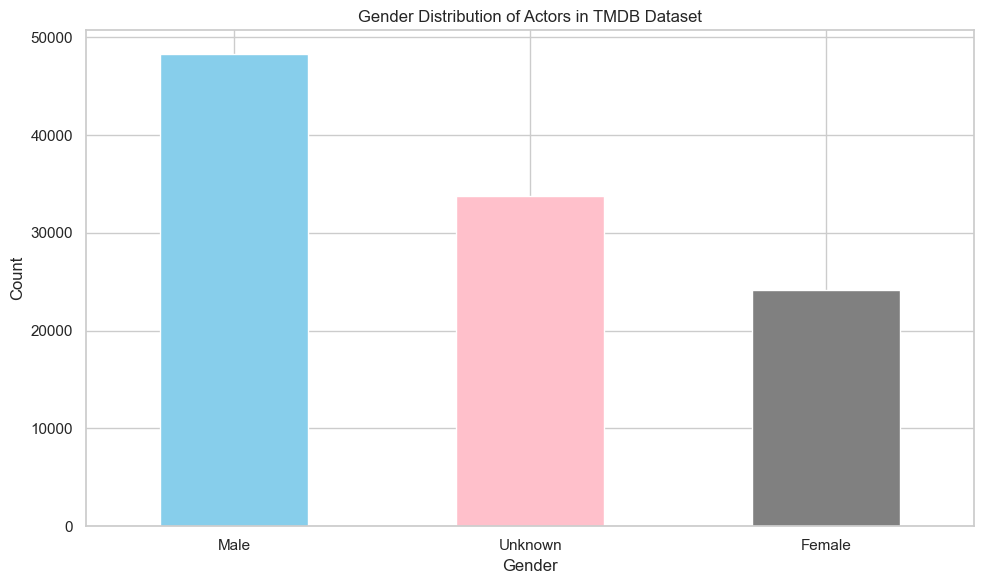

In [124]:
# Analyze actor popularity and gender distribution from TMDB data
# Extract actor gender information
actor_data = []
for _, row in df_tmdb_credits.iterrows():
    for cast_member in row['cast_parsed']:
        if isinstance(cast_member, dict) and 'gender' in cast_member and 'name' in cast_member:
            actor_data.append({
                'name': cast_member.get('name'),
                'gender': 'Female' if cast_member.get('gender') == 1 else 'Male' if cast_member.get('gender') == 2 else 'Unknown',
                'popularity': cast_member.get('popularity', 0)
            })

actor_df = pd.DataFrame(actor_data)

# Analyze gender distribution
gender_counts = actor_df['gender'].value_counts()
plt.figure(figsize=(10, 6))
gender_counts.plot(kind='bar', color=['skyblue', 'pink', 'gray'])
plt.title('Gender Distribution of Actors in TMDB Dataset')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [125]:
import plotly.express as px

fig = px.imshow(
    country_genre_pivot,
    labels=dict(x="Genre", y="Country", color="Movie Count"),
    x=country_genre_pivot.columns,
    y=country_genre_pivot.index,
    aspect="auto",
    color_continuous_scale="YlGnBu",
)
fig.update_layout(title="Genre Counts by Country (Matrix View)")
fig.show()

In [126]:
df_tmdb_credits

,movie_id,title,cast,crew,cast_parsed,crew_parsed,director,top_cast,title_lower
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",avatar
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]",pirates of the caribbean: at world's end
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",spectre
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]",the dark knight rises
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",john carter
...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...","[{'cast_id': 1, 'character': 'El Mariachi', 'c...","[{'credit_id': '52fe44eec3a36847f80b280b', 'de...",Robert Rodriguez,"[Carlos Gallardo, Jaime de Hoyos, Peter Marqua...",el mariachi
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...","[{'cast_id': 1, 'character': 'Buzzy', 'credit_...","[{'credit_id': '52fe487dc3a368484e0fb013', 'de...",Edward Burns,"[Edward Burns, Kerry Bishé, Marsha Dietlein]",newlyweds
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...","[{'cast_id': 8, 'character': 'Oliver O’Toole',...","[{'credit_id': '52fe4df3c3a36847f8275ecf', 'de...",Scott Smith,"[Eric Mabius, Kristin Booth, Crystal Lowe]","signed, sealed, delivered"
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de...","[{'cast_id': 3, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe4ad9c3a368484e16a36b', 'de...",Daniel Hsia,"[Daniel Henney, Eliza Coupe, Bill Paxton]",shanghai calling


In [127]:
df_wiki

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,Genre_list,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized,Title_lower,Decade
0,0,1901,Kansas Saloon Smashers,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",[unknown],['unknown'],[Unknown],['unknown'],[],a bartender is working at a saloon serving dri...,bartender work saloon serve drink customer fil...,kansas saloon smashers,1900
1,1,1901,Love by the Light of the Moon,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",[unknown],['unknown'],[Unknown],['unknown'],[],the moon painted with a smiling face hangs ove...,moon paint smile face hang park night young co...,love by the light of the moon,1900
2,2,1901,The Martyred Presidents,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",[unknown],['unknown'],[Unknown],['unknown'],[],the film just over a minute long is composed o...,film minute long compose shot girl sit base al...,the martyred presidents,1900
3,3,1901,"Terrible Teddy, the Grizzly King",American,NaN,Unknown,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,[unknown],['unknown'],[Unknown],['unknown'],[],lasting just seconds and consisting of two sho...,last second consist shot shot set wood winter ...,"terrible teddy, the grizzly king",1900
4,4,1902,Jack and the Beanstalk,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,[unknown],['unknown'],[Unknown],['unknown'],[],the earliest known adaptation of the classic f...,early know adaptation classic fairytale film s...,jack and the beanstalk,1900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,34881,2014,The Water Diviner,Turkish,Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...",[unknown],['unknown'],"[Selma Alispahic, Bucin Abdullah, Tina Cvitano...",['unknown'],[],the film begins in just after world war i has ...,film begin world war end centre joshua connor ...,the water diviner,2010
34882,34882,2017,Çalgı Çengi İkimiz,Turkish,NaN,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",[comedy],['comedy'],"[Remzi Pamukcu, Jale Arıkan, Özay Fecht, Rüçha...",['comedy'],['comedy'],two musicians salih and grkan described the ad...,musician salih grkan describe adventure cousin,çalgı çengi i̇kimiz,2010
34883,34883,2017,Olanlar Oldu,Turkish,NaN,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",[comedy],['comedy'],"[Müfit Can Saçıntı, Ayda Aksel, Eser Eyüboğlu,...",['comedy'],['comedy'],zafer a sailor living with his mother dnd in a...,zafer sailor live mother dnd coastal village i...,olanlar oldu,2010
34884,34884,2017,Non-Transferable,Turkish,NaN,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,"[romance, comedy]",['romantic comedy'],"[Haluk Bilginer, Tamer Levent, Demet Akbag, Ne...",['romantic comedy'],['comedy'],the film centres around a young woman named am...,film centre young woman name amy tyler book su...,non-transferable,2010


In [ ]:
df_wiki[(df_wiki['Director']!=df_wiki['director'] )& (df_wiki['director'].notna())][['Title', 'Director', 'director']]

,Title,Director,director
21154,The Three Musketeers,Paul W. S. Anderson,Paul W.S. Anderson
21198,Arthur Christmas,Sarah Smith,Barry Cook
21199,The Awakening,Nick Murphy,Nick Murphy
21234,Airborne,Dominic Burns,Rob Bowman
21337,Inside Llewyn Davis,"Joel Coen, Ethan Coen",Joel Coen
21338,The Last Days on Mars,Ruairí Robinson,Ruairi Robinson
21355,Stranded,Roger Christian,"Daniel Petrie, Jr."
21458,Hide and Seek,Joanna Coates,John Polson
21472,The Prince,Brian A. Miller,Brian A Miller
21476,Before I Go to Sleep,Rowan Joffé,Rowan Joffe


In [ ]:
top_10_directors = df_wiki[df_wiki['Genre']!='unknown']['Director'].value_counts().head(10).index.tolist()
top_10_directors

['Martin Scorsese',
 'Steven Spielberg',
 'Tim Burton',
 'Clint Eastwood',
 'Ridley Scott',
 'Joel Schumacher',
 'Paul W.S. Anderson',
 'Woody Allen',
 'Renny Harlin',
 'Robert Zemeckis']

In [ ]:
top_10_directors = df_wiki[df_wiki['Genre']!='unknown']['Director'].value_counts().head(10).index.tolist()
director_genre_df = df_wiki[df_wiki['Director'].isin(top_10_directors)].copy()
director_genre_df

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,...,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized,Decade,Cast_list_extracted,Director_extracted,top_cast,director
5,5,1903,Alice in Wonderland,American,Tim Burton,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...",['unknown'],...,"[May Clark, Mia Wasikowska, Johnny Depp, Anne ...",['unknown'],"[Mia Wasikowska, Johnny Depp, Anne Hathaway]",alice follows a large white rabbit down a rabb...,alice follow large white rabbit rabbithole fin...,1900,[May Clark],None,"[Mia Wasikowska, Johnny Depp, Anne Hathaway]",Tim Burton
20,20,1908,A Christmas Carol,American,Robert Zemeckis,Tom Ricketts,drama,https://en.wikipedia.org/wiki/A_Christmas_Caro...,No prints of the first American film adaptatio...,['drama'],...,"[Tom Ricketts, Gary Oldman, Jim Carrey, Steve ...",['drama'],"[drama, Gary Oldman, Jim Carrey, Steve Valentine]",no prints of the first american film adaptatio...,print american film adaptation christmas carol...,1900,[Tom Ricketts],None,"[Gary Oldman, Jim Carrey, Steve Valentine]",Robert Zemeckis
27,27,1910,A Christmas Carol,American,Robert Zemeckis,"Marc McDermott, Charles Stanton Ogle",unknown,https://en.wikipedia.org/wiki/A_Christmas_Caro...,"The day before Christmas, Ebenezer Scrooge ref...",['unknown'],...,"[Marc McDermott, Charles Stanton Ogle, Gary Ol...",['unknown'],"[Gary Oldman, Jim Carrey, Steve Valentine]",the day before christmas ebenezer scrooge refu...,day christmas ebenezer scrooge refuse contribu...,1910,"[Marc McDermott, Charles Stanton Ogle]",None,"[Gary Oldman, Jim Carrey, Steve Valentine]",Robert Zemeckis
446,446,1922,Robin Hood,American,Ridley Scott,Douglas Fairbanks,swashbuckler,https://en.wikipedia.org/wiki/Robin_Hood_(1922...,The opening has the dashing Earl of Huntingdon...,['swashbuckler'],...,"[Douglas Fairbanks, Russell Crowe, Cate Blanch...",['swashbuckler'],"[Russell Crowe, Cate Blanchett, Max von Sydow]",the opening has the dashing earl of huntingdon...,opening dash earl huntingdon best bitter enemy...,1920,[Douglas Fairbanks],None,"[Russell Crowe, Cate Blanchett, Max von Sydow]",Ridley Scott
482,482,1924,The Age of Innocence,American,Martin Scorsese,"Beverly Bayne, Edith Roberts",drama,https://en.wikipedia.org/wiki/The_Age_of_Innoc...,Newland Archer is engaged to May Mingott of a ...,['drama'],...,"[Beverly Bayne, Edith Roberts, Daniel Day-Lewi...",['drama'],"[drama, Daniel Day-Lewis, Michelle Pfeiffer, W...",newland archer is engaged to may mingott of a ...,newland archer engaged mingott prominent new y...,1920,"[Beverly Bayne, Edith Roberts]",None,"[Daniel Day-Lewis, Michelle Pfeiffer, Winona R...",Martin Scorsese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27885,27880,2005,Alice in Wonderland,Malayalam,Tim Burton,"Jayaram, Vineeth, Laya, Sandhya",unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,Alby's (Jayaram) sister Alice (Sandhya) is men...,['unknown'],...,"[Jayaram, Vineeth, Laya, Sandhya, Mia Wasikows...",['unknown'],"[Mia Wasikowska, Johnny Depp, Anne Hathaway]",albys jayaram sister alice sandhya is mentally...,albys jayaram sister alice sandhya mentally ch...,2000,"[Jayaram, Vineeth, Laya, Sandhya]",None,"[Mia Wasikowska, Johnny Depp, Anne Hathaway]",Tim Burton
28096,28091,2009,Robin Hood,Malayalam,Ridley Scott,"Prithwiraj, Narain, Bhavana, Jayasurya, Biju M...",unknown,https://en.wikipedia.org/wiki/Robin_Hood_(2009...,Venki (Prithviraj) is an entrance coaching pro...,['unknown'],...,"[Prithwiraj, Narain, Bhavana, Jayasurya, Biju ...",['unknown'],"[Russell Crowe, Cate Blanchett, Max von Sydow]",venki prithviraj is an entrance coaching profe...,venki prithviraj entrance coach professor day ...,2000,"[Prithwiraj, Narain, Bhavana, Jayasurya, Biju ...",None,"[Russell Crowe, Cate Blanchett, Max von Sydow]",Ridley Scott
33161,33156,1989,Black Rain,Japanese,Ridley 

In [ ]:
director_genre_df['Director']

5             Tim Burton
20       Robert Zemeckis
27       Robert Zemeckis
446         Ridley Scott
482      Martin Scorsese
              ...       
27885         Tim Burton
28096       Ridley Scott
33161       Ridley Scott
33476     Clint Eastwood
34467    Robert Zemeckis
Name: Director, Length: 198, dtype: object

In [ ]:
director_genre_df['genres_list']

5             ['unknown']
20              ['drama']
27            ['unknown']
446      ['swashbuckler']
482             ['drama']
               ...       
27885         ['unknown']
28096         ['unknown']
33161         ['unknown']
33476         ['unknown']
34467         ['unknown']
Name: genres_list, Length: 198, dtype: object

['Mia Wasikowska', 'Johnny Depp', 'Anne Hathaway']

In [ ]:

director_genre_df = df_wiki.explode('genres_list')
director_genre_df


,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,genres_list,Genre_list,Cast_list,genre_list_raw,genre_list,plot_clean,plot_lemmatized,Title_lower,Decade
0,0,1901,Kansas Saloon Smashers,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",unknown,['unknown'],[Unknown],['unknown'],[],a bartender is working at a saloon serving dri...,bartender work saloon serve drink customer fil...,kansas saloon smashers,1900
1,1,1901,Love by the Light of the Moon,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",unknown,['unknown'],[Unknown],['unknown'],[],the moon painted with a smiling face hangs ove...,moon paint smile face hang park night young co...,love by the light of the moon,1900
2,2,1901,The Martyred Presidents,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",unknown,['unknown'],[Unknown],['unknown'],[],the film just over a minute long is composed o...,film minute long compose shot girl sit base al...,the martyred presidents,1900
3,3,1901,"Terrible Teddy, the Grizzly King",American,NaN,Unknown,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,unknown,['unknown'],[Unknown],['unknown'],[],lasting just seconds and consisting of two sho...,last second consist shot shot set wood winter ...,"terrible teddy, the grizzly king",1900
4,4,1902,Jack and the Beanstalk,American,NaN,Unknown,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,unknown,['unknown'],[Unknown],['unknown'],[],the earliest known adaptation of the classic f...,early know adaptation classic fairytale film s...,jack and the beanstalk,1900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34882,34882,2017,Çalgı Çengi İkimiz,Turkish,NaN,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",comedy,['comedy'],"[Remzi Pamukcu, Jale Arıkan, Özay Fecht, Rüçha...",['comedy'],['comedy'],two musicians salih and grkan described the ad...,musician salih grkan describe adventure cousin,çalgı çengi i̇kimiz,2010
34883,34883,2017,Olanlar Oldu,Turkish,NaN,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",comedy,['comedy'],"[Müfit Can Saçıntı, Ayda Aksel, Eser Eyüboğlu,...",['comedy'],['comedy'],zafer a sailor living with his mother dnd in a...,zafer sailor live mother dnd coastal village i...,olanlar oldu,2010
34884,34884,2017,Non-Transferable,Turkish,NaN,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,romance,['romantic comedy'],"[Haluk Bilginer, Tamer Levent, Demet Akbag, Ne...",['romantic comedy'],['comedy'],the film centres around a young woman named am...,film centre young woman name amy tyler book su...,non-transferable,2010
34884,34884,2017,Non-Transferable,Turkish,NaN,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,comedy,['romantic comedy'],"[Haluk Bilginer, Tamer Levent, Demet Akbag, Ne...",['romantic comedy'],['comedy'],the film centres around a young woman named am...,film centre young woman name amy tyler book su...,non-transferable,2010


In [ ]:
# Create a pivot table: directors as rows, genres as columns
director_genre_pivot = pd.crosstab(director_genre_df['Director'], director_genre_df['genres_list'])
director_genre_pivot

genres_list,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,horror,music,mystery,romance,sci-fi,sport,thriller,unknown,war,western
Director,,,,,,,,,,,,,,,,,,,,,
Aaron Hann,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Aaron Schneider,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abel Ferrara,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Adam Brooks,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Adam Carolla,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhang Yimou,2,0,0,0,2,0,0,5,0,0,...,0,0,0,4,0,0,0,2,0,0
Zhora Kryzhovnikov,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Àlex Pastor,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Analyze the distribution of genres for each of the top 10 most prolific directors using Plotly

import plotly.express as px

fig = px.imshow(
    director_genre_pivot,
    labels=dict(x="Genre", y="director", color="Movie Count"),
    x=director_genre_pivot.columns,
    y=director_genre_pivot.index,
    aspect="auto",
    color_continuous_scale="YlGnBu",
)
fig.update_layout(title="Genre Distribution for Top 10 Directors")
fig.show()

## genre by country 

In [ ]:


for i in director_genre_df['genres_list'].unique():
    print(i)

unknown
western
comedy
crime
action
biography
drama
adventure
fantasy
sport
horror
history
documentary
romance
mystery
war
animation
family
thriller
music
sci-fi


In [ ]:
import plotly.express as px

# Explode genres_list for country-genre pairs
genre_country_df = df_wiki.explode('genres_list')

# Count movies per country and genre
country_genre_matrix = pd.crosstab(
    genre_country_df['Origin/Ethnicity'],
    genre_country_df['genres_list']
)

# Optional: Normalize by row to show proportions
# country_genre_matrix = country_genre_matrix.div(country_genre_matrix.sum(axis=1), axis=0)

fig = px.imshow(
    country_genre_matrix,
    labels=dict(x="Genre", y="Country", color="Movie Count"),
    x=country_genre_matrix.columns,
    y=country_genre_matrix.index,
    aspect="auto",
    color_continuous_scale="YlGnBu",

)
fig.update_layout(title="Movie Genre Counts by Country (Matrix View)")

fig.show()


## 5. Conclusion and Key Findings

In this notebook, we've explored movie data with a focus on genre behavior across countries and over time, as well as identifying notable actors and directors. Here are some key findings:

1. **Genre Trends by Country**: We observed distinct genre preferences across different countries, with some genres being more popular in certain regions.

2. **Genre Evolution Over Time**: The popularity of genres has evolved over the decades, with some genres rising in prominence while others declining.

3. **Notable Directors and Actors**: We identified the most prolific directors and actors, as well as how the prominent figures in the industry have changed over time.

4. **Gender Distribution**: Using the TMDB dataset, we analyzed the gender distribution among actors and found significant disparities.

These insights provide a comprehensive view of the movie industry's evolution and can inform further analysis and modeling efforts.